In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model
import torch
import torch.nn.functional as F
import torch.nn as nn

# Upload tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [8]:

# Load pre-trained GPT-2 (small version)
model = GPT2Model.from_pretrained("gpt2")

# Choose a layer index (e.g., 0 for the first transformer block)
layer_idx = 0

# Extract the FFNN (MLP) from the transformer block
ffnn = model.h[layer_idx].mlp

# Print the structure
print(ffnn)



GPT2MLP(
  (c_fc): Conv1D(nf=3072, nx=768)
  (c_proj): Conv1D(nf=768, nx=3072)
  (act): NewGELUActivation()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [10]:
# Extract weights and biases from the Conv1D layers
def convert_conv1d_to_linear(conv1d):
    # Conv1D in GPT-2 uses weight of shape (out_features, in_features)
    weight = conv1d.weight.T  # Shape: [in_features, out_features]
    bias = conv1d.bias
    return nn.Linear(weight.shape[0], weight.shape[1], bias=True).to(weight.device).load_state_dict({
        'weight': weight.T,
        'bias': bias
    }, strict=True)

# Extract components
fc1 = model.h[layer_idx].mlp.c_fc
proj = model.h[layer_idx].mlp.c_proj
act = model.h[layer_idx].mlp.act  # NewGELUActivation

# Recreate the FFNN as a PyTorch module
class GPT2FFNN(nn.Module):
    def __init__(self, fc1, proj, act):
        super().__init__()
        self.fc1 = nn.Linear(fc1.weight.shape[1], fc1.weight.shape[0])
        self.proj = nn.Linear(proj.weight.shape[1], proj.weight.shape[0])
        self.act = act  # This is already a module

        # Load weights
        self.fc1.weight.data = fc1.weight.T.clone()
        self.fc1.bias.data = fc1.bias.clone()
        self.proj.weight.data = proj.weight.T.clone()
        self.proj.bias.data = proj.bias.clone()

    def forward(self, x):
        return self.proj(self.act(self.fc1(x)))

# Instantiate
ffnn_reconstructed = GPT2FFNN(fc1, proj, act)



Values visualization and normalization

In [ ]:
#x = torch.randn(1, 768)  # corresponds to [batch_size, hidden_size]

# Create a vector of zeros
x = torch.zeros(768)

# Set elements 64 to 127 to 1 (second head block)
k=11
x[k*64:k*64+64] = 1.0

# Add batch dimension: [1, 768]
x = x.unsqueeze(0)

# Pass through FFNN
output = ffnn_reconstructed(x)

print(x.shape, output.shape)  # Should be [1, 768]
print(x[0][:3])
print(output[0][:3])
#print(output[0])
print(sum(x[0]), sum(output[0]), "\n")

sx = []
so = []
    
for k in range(12):
    x = torch.zeros(768)
    x[k*64:k*64+64] = 1.0
    x = x.unsqueeze(0)
    output = ffnn_reconstructed(x)
    print(k, sum(x[0]), sum(output[0]))
    sx.append(sum(x[0]))
    so.append(sum(output[0]))

print("\n", sum(sx), sum(so))


torch.Size([1, 768]) torch.Size([1, 768])
tensor([0., 0., 0.])
tensor([-2.8303, -2.4265,  0.0176], grad_fn=<SliceBackward0>)
tensor(64.) tensor(37.3757, grad_fn=<AddBackward0>) 

0 tensor(64.) tensor(1.8560, grad_fn=<AddBackward0>)
1 tensor(64.) tensor(50.0736, grad_fn=<AddBackward0>)
2 tensor(64.) tensor(39.2192, grad_fn=<AddBackward0>)
3 tensor(64.) tensor(19.9170, grad_fn=<AddBackward0>)
4 tensor(64.) tensor(39.7488, grad_fn=<AddBackward0>)
5 tensor(64.) tensor(-19.2324, grad_fn=<AddBackward0>)
6 tensor(64.) tensor(-69.2670, grad_fn=<AddBackward0>)
7 tensor(64.) tensor(38.5823, grad_fn=<AddBackward0>)
8 tensor(64.) tensor(27.8565, grad_fn=<AddBackward0>)
9 tensor(64.) tensor(31.7172, grad_fn=<AddBackward0>)
10 tensor(64.) tensor(-50.2816, grad_fn=<AddBackward0>)
11 tensor(64.) tensor(37.3757, grad_fn=<AddBackward0>)

 tensor(768.) tensor(147.5653, grad_fn=<AddBackward0>)


Colour Visualization

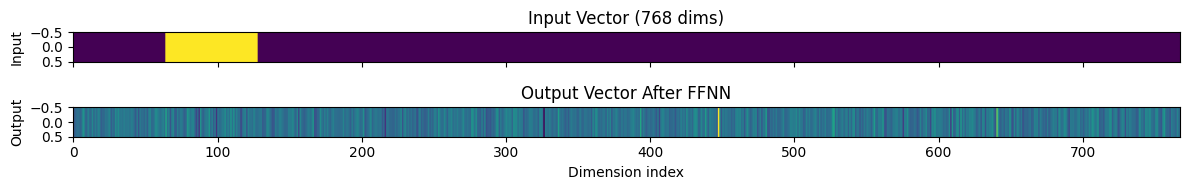

In [ ]:
# Create your input vector
x = torch.zeros(768)
x[64:128] = 1.0
x = x.unsqueeze(0)

# Get output from FFNN
with torch.no_grad():
    output = ffnn_reconstructed(x)

# Remove batch dimension
x_np = x.squeeze(0).numpy()
out_np = output.squeeze(0).numpy()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 2), sharex=True)

# Input heatmap
ax[0].imshow(x_np[np.newaxis, :], cmap='viridis', aspect='auto')
ax[0].set_title("Input Vector (768 dims)")
ax[0].set_ylabel("Input")

# Output heatmap
ax[1].imshow(out_np[np.newaxis, :], cmap='viridis', aspect='auto')
ax[1].set_title("Output Vector After FFNN")
ax[1].set_ylabel("Output")
ax[1].set_xlabel("Dimension index")
plt.tight_layout()
plt.show()
